In [2]:
import ChiantiPy.core as ch
import numpy as np

 ChiantiPy version 0.15.0 
 found PyQt5 widgets
 using PyQt5 widgets


In [3]:
'''
Calculate thermal bremmstrahlung emission using ChiantiPy freeFree function
Assming coronal conditions and emission at 20 keV
kT = 1.5e6 K

Ref. about astropy units & equivalences:
https://het.as.utexas.edu/HET/Software/Astropy-1.0/units/index.html
https://docs.astropy.org/en/stable/units/equivalencies.html
'''

from astropy import units as u # To simplify units conversion
temperature = np.array([1.5e6]) * u.K
kT_keV = temperature.to(u.keV, equivalencies=u.temperature_energy())
print(temperature.value, kT_keV.value)
#Define wavelength from energy in keV 
eph = np.array([9]) * u.keV
wave = eph.to(u.AA, equivalencies=u.spectral())
print(wave.value) # In angstroms


[1500000.] [0.12926]
[1.3776022]


In [4]:
em = np.array([1.e49])# Volumetric emission measure (cm-3)
#Define ionized hydrogen continuum
cont = ch.continuum('h_2',temperature.value, em=em)

cont.freeFree(wave.value, em=em)
print('Intensity: ',cont.FreeFree['intensity'])

'''
Intensity in units of erg cm3s−1 ̊A−1str−1. If the emission measure has been set, the units
will be multiplied by cm−5 or cm−3, depending on whether it is the line-of-sight or volumetric emission
measure, respectively
'''
# Set emission measure
if hasattr(cont,'Em'):
    print(' Emission Measure = %12.2e'%(cont.Em))
else:
    print(' the value for the emission measure is unspecified')
    
#print(type(cont.freeFree(wave)))#.value)))
#print(ch.continuum['intensity'])

Intensity:  1.104447245812427e-05
 Emission Measure =     1.00e+49


In [5]:
'''
Compare Gaunt factors
'''
print('Temperature: ', cont.Temperature, 'Wavelength: ', wave.value, '\n')
print('Mewe f-b G.f.', cont.mewe_gaunt_factor()) # Free-bound Gaunt-factor
print('Itoh f-f G.f.', cont.itoh_gaunt_factor(wave.value)) # Free-free Gaunt factor at a given wavelength
print('Sutherland f-f G.f.', cont.sutherland_gaunt_factor(wave.value)) # Relativistic f-f Gaunt factor

Temperature:  [1500000.] Wavelength:  [1.3776022] 

Mewe f-b G.f. [0.70733521]
Itoh f-f G.f. [[nan]]
Sutherland f-f G.f. [[0.27246143]]


Corresponding Gaunt factor returned by the IDL *ACGAUNT* function reads:


In [6]:
'''
Thermal bremsstrahlung function based on the brem_49.pro IDL subroutine
'''

acgaunt = 15.589282751083374
E = 1.5
KT0 = 0.12926

result = (1e8/9.26) * acgaunt*np.exp(-((E/KT0) if (E/KT0) < 50 else 50))/E/KT0**.5
print(result)

'''
Returns the differential photon flux in units of                                                                              
photons/(cm2 s keV) per (1e49 cm-3 emission measure) 
'''


2848.4832428356904


'\nReturns the differential photon flux in units of                                                                              \nphotons/(cm2 s keV) per (1e49 cm-3 emission measure) \n'

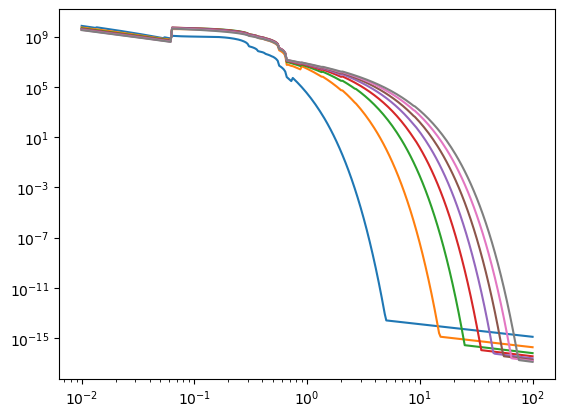

In [7]:
from matplotlib import pyplot as plt, cm
from brm_49 import brem_49

energies = np.logspace(-2,2,300)
kT = 0.15
kT_arr = np.linspace(0.100001, 1.5, 8)
#print(energies)
#print(brem_49(kT, energies))

for i in range(len(kT_arr)):
    plt.loglog(energies, brem_49(kT_arr[i], energies))
plt.show()

Make comparison with Greene'59 approximation for Gaunt factor

In [8]:
import ChiantiPy.core as ch

energies = np.logspace(-2,2,300) *  u.keV
kT_arr = np.linspace(0.100001, 1.5, 8) * u.keV
kT_ = kT_arr.to(u.K, equivalencies=u.temperature_energy())
kT0 = 1.0e7 * u.K
# print(kT0, kT_)

# print(wave.value)



In [9]:
from scipy.special import k0
from astropy import constants as const
from acgaunt import acgaunt

# kT_ = 2.0 * u.keV # 2.0 keV
# kT0 = kT_.to(u.erg, equivalencies=u.temperature_energy())

kT0 = 1.0e7 * u.K
kT6 = kT0 / 1e6
hp = (const.h).to(u.erg*u.s)
E_ = 6.0 * u.keV
E_0 = E_.to(u.erg)
E_0A = E_0.to(u.angstrom, equivalencies=u.spectral())

kT_ = np.logspace(6, 8, 5) * u.K
kT6_ = kT_ / 1e6
print(kT_.value)
print(kT6_.value)

print('kT6', kT6, 'E_0A', E_0A)

wave = energies.to(u.AA, equivalencies=u.spectral())
cont = ch.continuum('h_2', kT0.value, em=em)

'''
Greene'59 Gaunt factor
'''

def g_b(E_0, kT0):
    g_b_ = np.sqrt(3.)/np.pi
    g_b_ *= np.exp(E_0/(2.*kT0))
    g_b_ *= k0(E_0/(2.*kT0))
    return g_b_

print('kT0: ', kT0, 'E_0: ', E_0)
print('g_b: ', g_b(E_0.value, kT0.value))

print('g (acgaunt): ', acgaunt(np.array([E_0A.value]), np.array([kT6.value])))

[1.00000000e+06 3.16227766e+06 1.00000000e+07 3.16227766e+07
 1.00000000e+08]
[  1.           3.16227766  10.          31.6227766  100.        ]
kT6 10.0 K E_0A 2.0664033072200043 Angstrom
kT0:  10000000.0 K E_0:  9.613059803999998e-09 erg
g_b:  19.51005073201157
g (acgaunt):  [[1.52972556]]


[[1.93690145]]
8.950289161047063


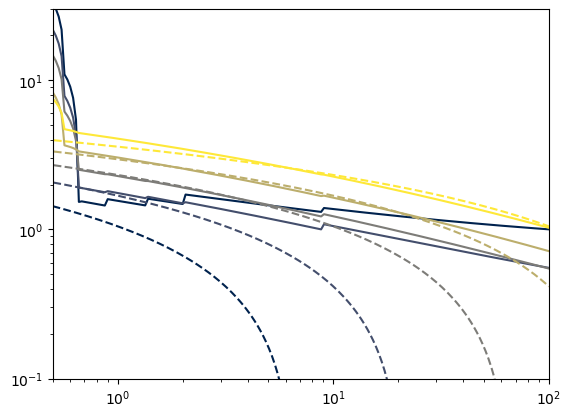

In [10]:
acgaunt_res = []
for i in range(len(kT_)):
    acgaunt_res.append(np.concatenate((list(map(acgaunt, np.divide(12.3985, energies.value),
		np.divide(np.array([kT6_[i].value]), 0.08617)*np.ones(len(energies.value))))), axis=1)[0])

'''
Normalize Gaunt Factor at 1 keV
'''
acg1 = acgaunt(np.divide(12.3985, 1.0), np.divide(np.array([5.0]), 0.08617))
g_b1 = g_b(1.0, 5e6)
e_1 = 1.0 * u.keV
wave_1 = e_1.to(u.AA, equivalencies=u.spectral())

print(acg1)
print(g_b1)

norm = g_b1 - acg1[0]
#norm = g_b1/acg1[0]
norm_2 = acg1[0] / cont.sutherland_gaunt_factor(wave_1.value)[0]

evenly_spaced_interval = np.linspace(0, 1, len(kT_))
colors = [cm.cividis(x) for x in evenly_spaced_interval]

for i in range(len(kT_.value)):
    plt.semilogx(energies.value, acgaunt_res[i], label='acgaunt '+str(kT_[i]), color = colors[i])
    #plt.semilogx(energies.value, g_b(energies.value, kT0.value), label='greene')
    #plt.semilogx(energies.value, cont.itoh_gaunt_factor(wave.value)[0])
    #plt.semilogx(energies.value, cont.sutherland_gaunt_factor(wave.value)[0], label='sutherland')
    #plt.semilogx(energies.value, cont.sutherland_gaunt_factor(wave.value)[0] * norm_2)
    plt.loglog(energies.value, g_b(energies.value, kT_[i].value) - norm, '--', label='gb_norm', color = colors[i])

plt.xlim(0.5, 100)
plt.ylim(0.1, 30)
#plt.legend(loc='upper left')
plt.savefig('gaunt_factors.eps')

In [11]:
energies.value.shape
print('norm', norm)

norm [7.01338771]


In [12]:
'''
Thermal bremsstrahlung estimations
'''

h = const.h.cgs.value
c = const.c.cgs.value
m = const.m_e.cgs.value
k_B = const.k_B.cgs.value
e = const.e.gauss.value # 4.8e-10

emfac = (2. ** 5) * np.pi * e ** 6 / (3. * m * c**3)
emfac *= np.sqrt(2 * np.pi / (3. * k_B * m))
print('emfac: ', emfac)

em_asch = (8. / 3.) * ((2. * np.pi / 3.) ** 0.5)
em_asch *= e**6 / (m**2 * c**3)
em_asch *= np.sqrt( m / (k_B))
print('emasch: ', em_asch)
print('4*pi*emasch: ', em_asch * 4. * np.pi)

emfac:  6.841593073876993e-38
emasch:  5.44436678165399e-39
4*pi*emasch:  6.841593073876992e-38


6.62607015e-27
1.380649e-16
23777788.69721373
10799136.06911447
ratio:  0.4541690653672899
Temp in MK:  [ 2.90112953  4.97336491  7.04560029  9.11783567 11.19007105 13.26230642
 15.3345418  17.40677718] MK
temp:  1.5
:  <class 'numpy.float64'>
result1 (3297.3479015326375, 3.660791560480977e-11)
result2 (7.191857998476815e-05, 7.977521749125296e-10)


TypeError: 'float' object does not support item assignment

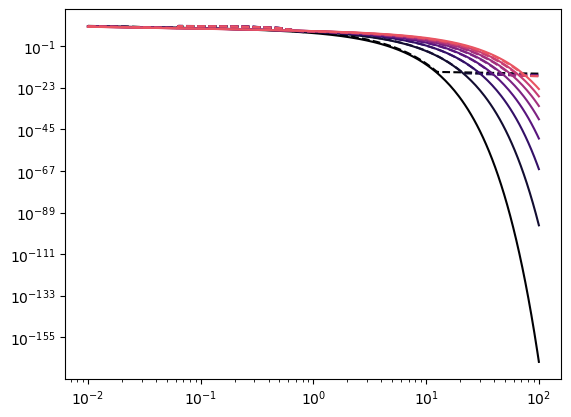

In [26]:
'''
Testing brm_49 equation in comparison to the photon emissivity given by Aschwanden
'''

import scipy.integrate as integrate
import scipy.special as special

print(h)
print(k_B)
k_B_keV = const.k_B.to(u.keV/u.K).value

factor_49 = 8.1e-39 * 1e49 * np.sqrt(k_B_keV)
print(factor_49)
print(1.e8/9.26)
print('ratio: ', 1.e8/(9.26*factor_49))

energies = np.logspace(-2,2,300)
kT = 0.15
kT_arr = np.linspace(0.25, 1.5, 8)
print('Temp in MK: ', (kT_arr*u.keV).to(u.MK, equivalencies=u.temperature_energy()))

evenly_spaced_interval = np.linspace(0, 1, int(1.5*len(kT_arr)))
colors = [cm.magma(x) for x in evenly_spaced_interval]

for i in range(len(kT_arr)):
    plt.loglog(energies, brem_49(kT_arr[i], energies), '--', color = colors[i])
    plt.loglog(energies, factor_49*np.exp(-energies/kT_arr[i])/(energies*np.sqrt(kT_arr[i])), color = colors[i])

print('temp: ', kT_arr[len(kT_arr)-1])
print(': ', type(factor_49))
flux_max = integrate.quad(lambda x: factor_49*np.exp(-x/kT_arr[len(kT_arr)-2])/(x*np.sqrt(kT_arr[len(kT_arr)-1])), 6., 6.1)
flux_min = integrate.quad(lambda x: factor_49*np.exp(-x/kT_arr[0])/(x*np.sqrt(kT_arr[0])), 6., 12.)
print('result1', flux_max)
print('result2', flux_min)
print('trhi',brem_49(1.6, 6.0))

#plt.axhline(y = flux_max[0], color = 'r', linestyle = '-')
#plt.axhline(y = brem_49(kT_arr[-1], 6.0)[0], color = 'r', linestyle = '-')
plt.axhline(y = flux_min[0], color = 'r', linestyle = '--')
plt.axhline(y = 39556.321419566506, color = 'b', linestyle = '-', label='pyxsim.CIESourceModel')
plt.axhline(y = 47172.86794542946, color = 'cyan', linestyle = '-', label='ThermBrem model')
plt.axvline(x = 6, color = 'b')#, label = 'axvline - full height')

plt.legend()

plt.xlim(1e-1,1e2)
plt.ylim(1e-6,1e11)
plt.xlabel("Photon energy, keV")
plt.ylabel("Photon flux, phot s$^{-1}$ cm$^{-2}$ keV$^{-1}$")
plt.show()
plt.savefig('comp.png')

In [14]:
'''
Convert distance
'''

print(const.au.to(u.cm)) # 1.496 × 10^13 cm


14959787070000.0 cm
